In [1]:
import os
import glob
import torch
import numpy as np
from PIL import Image, ImageEnhance
from torch.utils.data import Dataset
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import random


LABELS = ['Normal', 'Benign', 'InSitu', 'Invasive']
IMAGE_SIZE = (2048, 1536)
PATCH_SIZE = 512
DATASET_PATH = '/content/drive/MyDrive/CI Final Project/ICAR 2018 BACH Dataset'


In [ ]:
class BreaatCancerDataset(Dataset):
    def __init__(self, path, rotate=False, flip=False, enhance=False):
        super().__init__()

        dataset = {name: index for index in range(len(LABELS)) for name in glob.glob(path + '/' + LABELS[index] + '/*.tif')}
        self.path = path
        self.dataset = dataset
        self.names = list(sorted(dataset.keys()))
        self.rotate = rotate
        self.flip = flip
        self.enhance = enhance

        self.flip_options = [Image.FLIP_LEFT_RIGHT, Image.FLIP_TOP_BOTTOM]

      
    def __crop_img__(self, img, size, n):

        h, w, c = img.shape
        crops = []
        
        for _ in range(n):
            top = np.random.randint(low=0, high=h - size + 1)
            left = np.random.randint(low=0, high=w - size + 1)
            crop = img[top: top + size, left: left + size].copy()
            crop = np.rot90(crop, np.random.randint(low=0, high=4))
            if np.random.random() > 0.5:
                crop = np.flipud(crop)
            if np.random.random() > 0.5:
                crop = np.fliplr(crop)
            crops.append(crop)

        crops = np.stack(crops)
        return crops

    def __getitem__(self, index):
        img_path = self.names[index]
        label = self.dataset[img_path]
        with Image.open(img_path) as img:

            # Apply flip or not
            if random.randint(0,1) == 1 and self.flip:
              flip_random_ind = random.randint(0,1)
              print(f'Flip Index: {flip_random_ind}')
              img = img.transpose(self.flip_options[flip_random_ind])
            else: 
              print(f'Flip Not Applied')

            if self.rotate:
              rotate_random_angle = random.randint(0,3)
              print(f'Rotation: {rotate_random_angle * 90}')
              img = img.rotate(rotate_random_angle * 90)

            # Apply enhance or not
            if random.randint(0,1) == 1 and self.enhance:
              factors = np.random.uniform(.5, 1.5, 3)

              print(f'Color Enhance: {factors[0]}')
              print(f'Contrast Enhance: {factors[1]}')
              print(f'Brightness Enhannce: {factors[2]}')

              img = ImageEnhance.Color(img).enhance(factors[0])
              img = ImageEnhance.Contrast(img).enhance(factors[1])
              img = ImageEnhance.Brightness(img).enhance(factors[2])
            else:
              print(f'Enhance not applied')


            img = transforms.ToTensor()(img)

            crops = self.__crop_img__(img.permute(1,2,0).numpy(), 1024, 20)

            return crops, label

    def __len__(self):
        return len(self.dataset)



Flip Index: 1
Rotation: 180
Color Enhance: 0.6011257504826526
Contrast Enhance: 1.2325332108341573
Brightness Enhannce: 1.0303515458536041
20


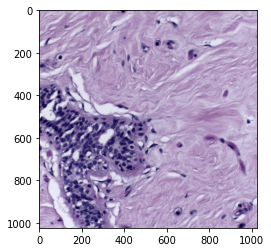

In [ ]:
dataset = BreaatCancerDataset(DATASET_PATH, rotate=True, flip=True, enhance=True)
# dataset = BreaatCancerDataset(DATASET_PATH)
plt.imshow(dataset[0][0][0])